In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.skip import skip
from models import spatial
import torch
import torch.optim

from torch.autograd import Variable
from utils.inpainting_utils import *
from utils.common_utils import write_video

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

from IPython.display import HTML

PLOT = True

import skvideo.io
from skimage.transform import resize
from collections import namedtuple

In [2]:
from torchvision.models.vgg import vgg16

In [3]:
def numpyToVar(x, requires_grad=False):
    xs = torch.FloatTensor(x)
    xs = xs.cuda()
    return Variable(xs, requires_grad=requires_grad)

In [4]:
T = 64
M = 10
N = 128

k = N
r = N

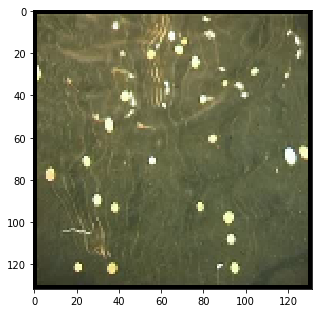

In [5]:
video_1 = skvideo.io.vread(fname='data/6489b10.avi')
data = np.transpose(video_1[:64], [0, 3, 1, 2])
data = np.array(list(map(lambda x: resize(x, output_shape=(3, N, N), mode='constant'), data)))
plot_image_grid([data[0]], factor=4);

In [6]:
x, y = np.meshgrid(np.arange(k), np.arange(r))
x = numpyToVar(np.array(x, dtype=np.float32))
y = numpyToVar(np.array(y, dtype=np.float32))

In [7]:
alpha = numpyToVar(np.random.normal(0, 0.1, M), requires_grad=True)
beta = numpyToVar(np.random.normal(0, 0.1, M), requires_grad=True)
gamma = numpyToVar(np.random.normal(0, 0.1, M), requires_grad=True)
delta = numpyToVar(np.random.normal(0, 0.1, M), requires_grad=True)

In [8]:
random_data = numpyToVar(np.zeros((T, M, k, r)))
random_data += x[None, :, :] * alpha[:, None, None] + y[None, :, :]  * beta[:, None, None] + delta[:, None, None]
random_data += torch.ger(Variable(torch.arange(0, T)).cuda(),  gamma)[:, :, None, None]

In [9]:
net_input = torch.sin(random_data)

In [10]:
true_video = torch.FloatTensor(data)
true_video = true_video.cuda()

In [11]:
LR = 0.01
OPT_OVER = 'net'
OPTIMIZER= 'adam' # 'LBFGS'
pad = 'reflection'
show_every = 300
reg_noise_std = 0
num_iter = 2000

input_depth = M 
figsize = 5

In [12]:
skip_params = {'num_input_channels': input_depth,
               'num_channels_down': [8, 16, 24, 32, 64],
               'num_channels_up': [8, 16, 24, 32, 64]}
net = spatial.Net(input_depth=input_depth, pic_size=N, skip_args=skip_params)
net = net.type(dtype)

true_video = Variable(true_video)

In [13]:
# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

Number of params: 166795


In [14]:
LossOutput = namedtuple("LossOutput", ["relu1_2"])

class LossNetwork(torch.nn.Module):
    def __init__(self, vgg_model):
        super(LossNetwork, self).__init__()
        self.vgg_layers = vgg_model.features
        self.layer_name_mapping = {
            '3': "relu1_2"
        }
    
    def forward(self, x):

        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                return x
def mse_loss(input, target):
    return torch.sum((input - target) ** 2) / input.data.nelement()

In [15]:
vgg_model = vgg16(pretrained=True)

In [16]:
loss_network = LossNetwork(vgg_model.cuda())
loss_network.eval()

LossNetwork (
  (vgg_layers): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=

Starting optimization with ADAM


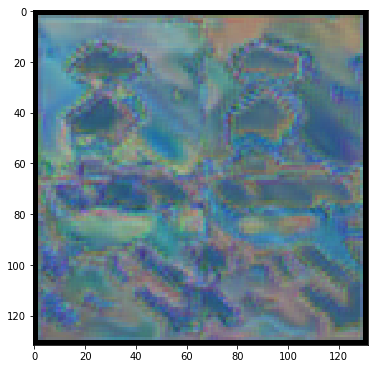

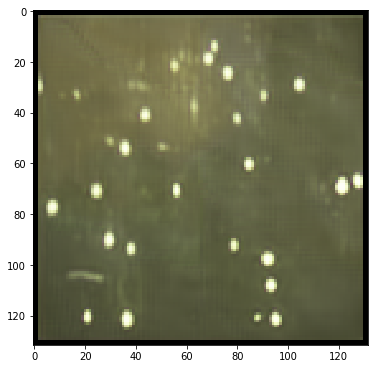

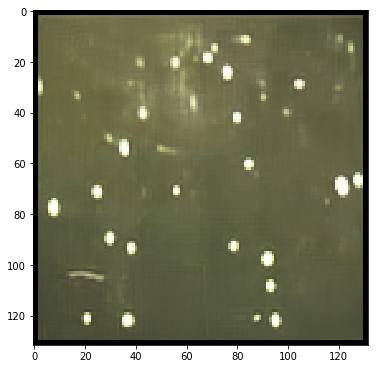

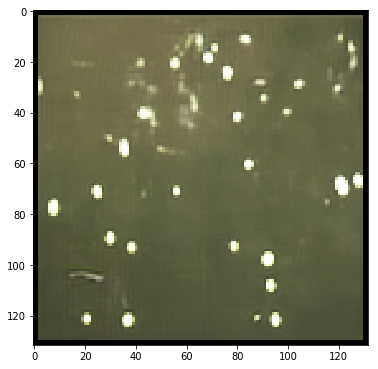

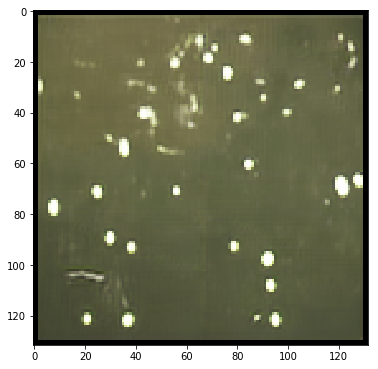

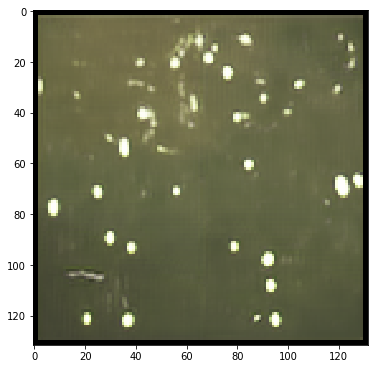

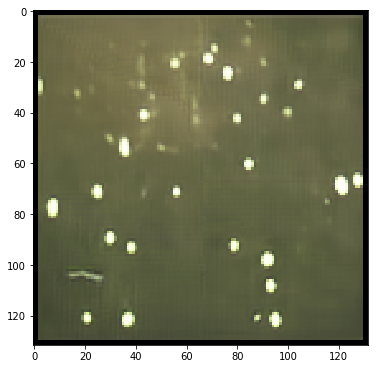

In [17]:
net_input_saved = net_input.data.clone()
noise = net_input.data.clone()

i = 0
def closure():
    
    global i
    random_data = numpyToVar(np.zeros((T, M, k, r)))
    random_data += x[None, :, :] * alpha[:, None, None] + y[None, :, :]  * beta[:, None, None] + delta[:, None, None]
    random_data += torch.ger(Variable(torch.arange(0, T)).cuda(),  gamma)[:, :, None, None]
    net_input = torch.sin(random_data)
    
    if reg_noise_std > 0:
        net_input.data = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
   
    total_loss = mse_loss(out, true_video) + mse_loss(loss_network(out), loss_network(true_video))
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.data[0]), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = net(net_input)[0].cpu().data.numpy()
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
p += [alpha, beta, gamma, delta]
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [18]:
delta_T = 256

random_data = numpyToVar(np.zeros((delta_T, M, k, r)))
random_data += x[None, :, :] * alpha[:, None, None] + y[None, :, :]  * beta[:, None, None] + delta[:, None, None]
random_data += torch.ger(Variable(torch.arange(0, delta_T)).cuda(),  gamma)[:, :, None, None]

pred_input = torch.sin(random_data)

In [19]:
outputdata = np.clip(np.transpose(net(pred_input).cpu().data.numpy(), (0, 2, 3, 1)), 0, 1)

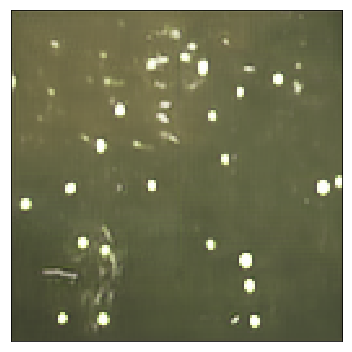

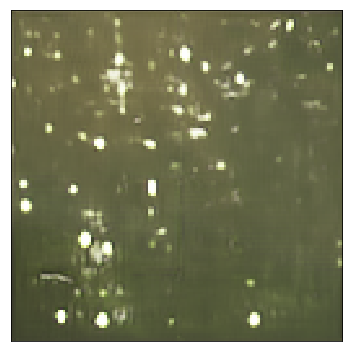

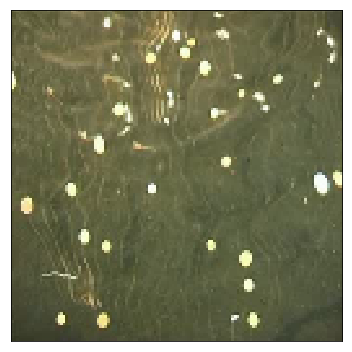

In [20]:
write_video("11transformer.texture_input.learn_weights.fit.6489b10.mp4", outputdata[:64])
write_video("11transformer.texture_input.learn_weights.predict.6489b10.mp4", outputdata[64:])
write_video("original_6489b10.mp4", np.transpose(data, (0, 2, 3, 1)));

In [21]:
%%HTML
<video width="320" height="240" controls loop>
  <source src="11transformer.texture_input.learn_weights.fit.6489b10.mp4" type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src="11transformer.texture_input.learn_weights.predict.6489b10.mp4" type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src="original_6489b10.mp4" type="video/mp4">
</video>